# Data Pre-Processing and Visualisation

In [ ]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from textblob import TextBlob
from textblob import Word

# General Pre-Processing
- NA, missing values, convert numbers to int

In [ ]:
missing_values = ["n/a", "na","N.A.","--"]     #import csv and clean up NA values
test = pd.read_csv('exp_tweet_week9.csv',encoding = "ISO-8859-1",skiprows = 1,na_values = missing_values)

test['text'].replace(np.nan,int(0),inplace = True)     #replace NA text with int(0)

test['user_id'].fillna(0,inplace = True)               #fill missing values with 0

test['user_id'] = test['user_id'].apply(lambda x: int(x))  #convert numbers to int

test['followers'] = test['followers'].apply(lambda x: int(x) if str(x).isnumeric() else int(0)) #convert numbers to int

median = test['followers'].median()
test['followers'].replace(0, median, inplace=True)   #replace missing numbers with median

# Feature Extraction

## Numbers (Binning)

In [ ]:
#plot the percentile values
values = pd.Series([int(np.percentile(test["followers"],i)) for i in range(10,100,5)])
values.plot.bar()
print(values)

#check last 5% of sorted col
test["followers"].sort_values().tail(int(len(test["followers"])*0.05))

#binning
bins = [mmin, 2085, 95714,  mmax]
labels =['low','median','high']
test['popularity_bin'] = pd.cut(test['followers'], bins,labels=labels)  #create DF column for binning
print(pd.value_counts(test['popularity_bin']))   #to check counts for each bin


## Text

In [ ]:
p = re.compile('RT\s*@(?P<target>[^:]*):')
test['retweet_target']=test['text'].apply(lambda x: p.match(str(x)).group('target') if p.match(str(x)) else '') #extract retweet

tokens = [re.split(r'([\n][ ]*?[\n]){1,}',t) for t in tokens]      #using regex to split strings in list

tokens = [re.sub(r'U.S.',"United States",x) for x in tokens]       #using regex to sub part of string in list

test['word_count'] = test['text'].apply(lambda x: len(str(x).split(" ")))    #number of words

test['text']=test['text'].apply(str)              #number of characters including spaces
test['char_count'] = test['text'].apply(len)

test['char_count'] = test['text'].apply(lambda x: len("".join(str(x).split(" "))))   #no. of characters excluding spaces

test['avg_word'] = test['text'].apply(lambda x: len("".join(str(x).split(" ")))/ len(str(x).split(" ")))  #avg word len

test['hastags'] = test['text'].apply(lambda x: len([x for x in x.split() if x.startswith('#')])) #no of hastags

test['numerics'] = test['text'].apply(lambda x: len([x for x in x.split() if x.isnumeric()]))    #no of numbers

test['upper'] = test['text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))  #no of uppercase words

from nltk.corpus import stopwords
stop = stopwords.words('english')
test['stopwords'] = test['text'].apply(lambda x: len([w for w in x.split() if w in stop]))   #no of stop words

# Text Pre-Processing

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
from textblob import Word

#BASIC#

#0)break text into sentences
tokens = nltk.sent_tokenize(txt)    #tokenize into sentences from txt file
#1)change text to lowercase
test['text'] = test['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))  
#2)remove punctuation
test['text'] = test['text'].str.replace('[^\w\s]','')   
#3)remove "rt" from text [cleanup]
test['text'] = test['text'].str.replace('rt\s\w+','')   

#4)remove stop words
from nltk.corpus import stopwords
stop = stopwords.words('english')
test['text'] = test['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop)) 

#5)remove top 10 freq words
freq = pd.Series(' '.join(test['text']).split()).value_counts()[:10]  
test['text'] = test['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))   

#6)remove top 10 least freq words
rare = pd.Series(' '.join(test['text']).split()).value_counts()[-10:]
test['text'] = test['text'].apply(lambda x: " ".join(x for x in x.split() if x not in rare))   

#7)correct spelling
from textblob import TextBlob
test['text'] = test['text'].apply(lambda x: str(TextBlob(x).correct()))   

#8)tokenisation
TextBlob(test['text'][1]).words       #tokenize into list of words
TextBlob(test['text'][1]).sentences   #tokenize into list of sentences

#9)stemming (not preferred)
from nltk.stem import PorterStemmer
st = PorterStemmer()
test['text'] = test['text'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))   

#10)lemmatization
from textblob import Word
test['text'] = test['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))  

#ADVANCED#

#1)N-grams
TextBlob(test['text'][1]).ngrams(2)   


#2)to find unique words 
from sklearn.feature_extraction.text import TfidfVectorizer                           
tfidf = TfidfVectorizer(max_features=1000,lowercase=True,analyzer='word',stop_words='english',ngram_range=(1,1))  #build text corpus
tfidf.fit(test['freq'])
test_vect = tfidf.transform(test['text'])  #get tfidf matrix as sparse matrix. can fit_transform if no existing vocab
tfidfmatrix = np.asarray(test_vect.mean(axis=0)).ravel().tolist()      
tfidfmatrix = pd.DataFrame({'word': tfidf.get_feature_names(), 'tfidf': tfidfmatrix, 'idf':tfidf.idf_}) #get word, tfidf, idf
tfidfmatrix.sort_values(by=["tfidf"],ascending=False)


#3)bag of words
from sklearn.feature_extraction.text import CountVectorizer                            
bow = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,1),analyzer = "word")
train_bow = bow.fit_transform(test['text'])  #get bag of words model
wordnet = pd.DataFrame(train_bow.toarray(), index=test.index, columns=bow.get_feature_names())


from sklearn.feature_extraction.text import CountVectorizer                   #get freq of bigrams
word_vectorizer = CountVectorizer(ngram_range=(2,2), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(df['description'])
frequencies = sum(sparse_matrix).toarray()[0]
pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])


#4)check sentiment: returns polarity (1: positive, -1:negative) and subjectivity (0:objective, 1:subjective)
test['text'][:5].apply(lambda x: TextBlob(x).sentiment)                     
test['sentiment'] = test['text'].apply(lambda x: TextBlob(x).sentiment[0] )  #create col of polarity from sentiment


#ALTERNATIVE

def get_keywords(row):     
    # split into tokens by white space
      tokens = row.split()
    # prepare regex for char filtering
      re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
      tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
      tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
      stop_words = set(stopwords.words('english'))
      tokens = [w for w in tokens if w not in stop_words]
    # stemming of words
      porter = PorterStemmer()
      stemmed = [porter.stem(word) for word in tokens]
    # filter out short tokens
      tokens = [word for word in tokens if len(word) > 1]
      return tokens

# TextBlob (Extras)

In [ ]:
z = TextBlob("Python is a high-level")

#can apply python string methods
z[3:6]  #to slice string
z.upper()
z.find("high")

#eg to access sentences:
for sentence in z.sentences:
    print(sentence.sentiment)                #sentiment of each sentence
    print(sentence.start, sentence.end)      #start and end indices of sentences in textblob
    
z.words[2].singularize()   #make word @ idx 2 singular
z.words.pluralize()        #make all words plural

z.words.count('is', case_sensitive=True)   #check freq of words

w = Word("went")
w.lemmatize("v")       #lemmmatize word to verb

w.spellcheck()         #return suggestion via tuples of (word,confidence)

## Plotting

### Matplotlib

In [ ]:
test['word_count'].iloc[0:20].plot.hist()           #histogram 
test['word_count'].iloc[0:20].plot.line()           #line graph
test['word_count'].iloc[0:20].plot.bar()            #bar graph
test['word_count'].iloc[0:20].plot.area()           #area graph
test['word_count'].iloc[0:20].plot.box()            #box plot
test['popularity_bin'].value_counts().plot.pie()    #pie chart
test['word_count'].iloc[0:20].plot.scatter()        #scatter plot


import matplotlib.pyplot as plt                        #to plot subplots
fig, axs = plt.subplots(2, 2, figsize=(5, 5))          #to set size of plot
axs[0, 0].hist(data[0])
axs[1, 0].scatter(data[0], data[1])
axs[0, 1].plot(data[0], data[1])
axs[1, 1].hist2d(data[0], data[1])
plt.show()


test["followers"].sort_values().tail(int(len(test["followers"])*0.05)).plot.bar()  #plot last 5% of sorted col 

### Seaborn

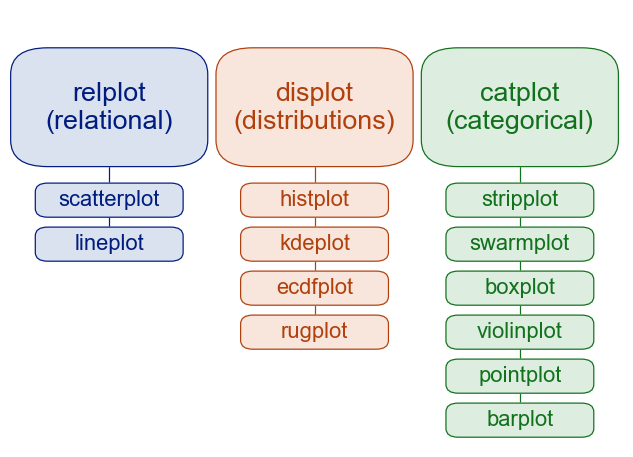

#### Relational
- Visualise the relationship between 2 or more variables
- hue, style, size allows up to 3 additional variables to be plotted. if too cluttered, use relplot

In [ ]:
#scatter plot: show relationship between two variables
sns.scatterplot(data=tips, x="total_bill", y="tip", hue="day", style="time") #vary color by day, vary marker by time
sns.scatterplot(data=tips, x="total_bill", y="tip", hue="size", size="size") #vary color by size, vary marker size by size

#line of best fit for different groups: understand how two variables change with respect to each other w/ 95% confidence interval
sns.lmplot(x="total_bill", y="tip", hue="smoker", data=tips) 
sns.lmplot(x="total_bill", y="tip", hue="smoker", col="time", row="sex", data=tips) #multiple plots

#line plot: variation of one variable over another continuous variable (eg time)
sns.lineplot(data=flights, x="year", y="passengers", hue="month", style="month")

#correlation matrix (heatmap): correlation metric between all possible pairs of numeric variables
sns.heatmap(test.corr(), square=True)

#relplot: multiple plots to show variance of other variables to minimise clutter
sns.relplot(x="total_bill", y="tip", hue="smoker", col="time", row="day", data=tips) #col of graphs due to time, row of graphs due to day


#### Distribution
- visualise frequency distribution 
- hue allows up to 1 additional variables to be plotted

In [ ]:
#Univariate distribution

#histogram: frequency distribution of a given continuous/discrete variable w/ binning
#hard to see when too many variables are involved
sns.displot(penguins, x="flipper_length_mm", bins=20, hue="species") #specify no. of bins and color by species

#kernel density estimation (KDE): frequency distribution of a given continuous/discrete variable w/o binning
#Important features of the data are easy to discern (central tendency, bimodality, skew)
#Afford easy comparisons between subsets. 
#KDE might poorly represent data. KDE will always show a smooth curve, even when the data themselves are not smooth. 
#Unrealistic data could appear (eg. negative values)
sns.displot(penguins, x="flipper_length_mm", hue="species", kind="kde", fill=True)   #color by species


#Bivariate distribution

#bivariate histogram: like heatmap
sns.displot(penguins, x="bill_length_mm", y="bill_depth_mm", hue="species", rug=True) #rug to show actual observations

#kde:
sns.displot(penguins, x="bill_length_mm", y="bill_depth_mm", hue="species", kind="kde")

#by default: bivariate dist using scatterplot and marginal dist using histplot
sns.jointplot(data=penguins, x="bill_length_mm", y="bill_depth_mm", hue="species", kind="kde")
sns.jointplot(data=penguins, x="bill_length_mm", y="bill_depth_mm", hue="species", kind="hex")


#pairwise plot: understand the relationship between all possible pairs of numeric variables (bivariate analysis)
sns.pairplot(df, kind="scatter", hue="species")

#### Categorical
- hue allows up to 1 additional variables to be plotted

In [ ]:
#Scatterplot
sns.catplot(x="day", y="total_bill", jitter=False, data=tips) #jitter=True to show overlapping points
sns.catplot(x="day", y="total_bill", hue="sex", kind="swarm", data=tips)  #to avoid overlapping of points
sns.catplot(x="popularity_bin", y="avg_word", kind = "swarm", col = "retweet_tag", data = test)  #separate graph to show col
sns.catplot(x="smoker", y="tip", order=["No", "Yes"], data=tips)  #to set the order of the categories



#Distribution plot

#box plot: This kind of plot shows the three quartile values of the distribution along with extreme values
sns.catplot(x="day", y="total_bill", hue="smoker", kind="box", data=tips)

#boxen plot: similar to a box plot but optimized for showing more information about the shape of the distribution. 
#It is best suited for larger datasets
sns.catplot(x="color", y="price", kind="boxen", data=diamonds.sort_values("color"))

#violin plot: boxplot with the kernel density estimation
sns.catplot(x="total_bill", y="day", hue="sex", kind="violin", data=tips)
sns.catplot(x="day", y="total_bill", hue="sex",kind="violin", inner="stick", split=True, data=tips) #“split” the violins when the hue parameter has only two levels, which can allow for a more efficient use of space. Sticks to show actual observations

#combine swarmplot and boxplot/violinplot
g = sns.catplot(x="popularity_bin", y="word_count", hue = "retweet_tag", kind = "violin", split = True,data=test)
sns.catplot(x="popularity_bin", y="word_count", hue = "retweet_tag", kind = "swarm", ax=g.ax,  data=test)



#Estimate plot

#bar plot: show mean of each category
sns.catplot(x="sex", y="survived", hue="class", kind="bar", data=titanic)

#count plot: number of observations in each category
sns.catplot(x="deck", kind="count", data=titanic)

#point plot: plots the point estimate and confidence interval, connects points from the same hue category.
sns.catplot(x="sex", y="survived", hue="class", kind="point", data=titanic)



#Multiple plots
sns.catplot(x="day", y="total_bill", hue="smoker", col="time", kind="swarm", data=tips)


#### Others

In [ ]:
#Deviation: visualize the variance based on a single metric

#diverging bars: see how  items are varying based on a single metric and visualize the order and amount of this variance
df['mpg_z'] = (x - x.mean())/x.std()
df['colors'] = ['red' if x < 0 else 'green' for x in df['mpg_z']]
df.sort_values('mpg_z', inplace=True)
df.reset_index(inplace=True)
plt.hlines(y=df.index, xmin=0, xmax=df.mpg_z, color=df.colors, alpha=0.4, linewidth=5)

In [ ]:
#Ranking
    
#ordered bar chart: convey the rank order of the items effectively
df = df_raw[['cty', 'manufacturer']].groupby('manufacturer').apply(lambda x: x.mean())
df.sort_values('cty', inplace=True)
df.reset_index(inplace=True)
plt.vlines(x=df.index, ymin=0, ymax=df.cty, color='firebrick', alpha=0.7, linewidth=20)

# Stats Concepts

In statistics, a central tendency (or measure of central tendency) is a central or typical value for a probability distribution.[1] It may also be called a center or location of the distribution. The most common measures of central tendency are the arithmetic mean, the median, and the mode. 

In statistics, a Multimodal distribution is a probability distribution with two different modes, which may also be referred to as a bimodal distribution. These appear as distinct peaks (local maxima) in the probability density function.

In probability theory and statistics, skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. For a unimodal distribution, negative skew commonly indicates that the tail is on the left side of the distribution, and positive skew indicates that the tail is on the right. 